In [1]:
# 1. Essential Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set a seed for reproducibility
np.random.seed(42)


In [2]:

# 2. Data Ingestion
HOUSING_CSV_PATH = "Housing.csv"  # Path to the housing dataset
housing_df = pd.read_csv(HOUSING_CSV_PATH)
print("Displaying initial data rows:")
print(housing_df.head())



Displaying initial data rows:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


In [ ]:
# 3. Data Transformation and Preparation
# Convert binary text columns to 0/1
binary_cols = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
for col_name in binary_cols:
    housing_df[col_name] = housing_df[col_name].map({"yes": 1, "no": 0})

# Apply one-hot encoding to the furnishing status column
housing_df = pd.get_dummies(housing_df, columns=["furnishingstatus"], prefix="furnish", drop_first=True)

# Impute missing values using the column mean
housing_df.fillna(housing_df.mean(numeric_only=True), inplace=True)

# ---- Intelligent Target Scaling ----
# Scale the target 'price' to have a mean around 10 for stable training
target_scaler = np.mean(housing_df["price"]) / 10
housing_df["price"] = housing_df["price"] / target_scaler

# Feature engineering: create a new feature for area per bedroom
housing_df["area_bedroom_ratio"] = housing_df["area"] / (housing_df["bedrooms"] + 1)

# Separate features (X) and target (y)
feature_matrix = housing_df.drop(columns=["price"]).values.astype(float)
target_vector = housing_df["price"].values.reshape(-1, 1).astype(float)

# Standardize feature matrix (Z-score normalization)
feature_means = feature_matrix.mean(axis=0)
feature_stds = feature_matrix.std(axis=0)
feature_stds[feature_stds == 0] = 1  # Avoid division by zero
feature_matrix_scaled = (feature_matrix - feature_means) / feature_stds

# Create training and testing splits (80/20)
num_samples = feature_matrix_scaled.shape[0]
shuffled_indices = np.arange(num_samples)
np.random.shuffle(shuffled_indices)
train_test_split_point = int(num_samples * 0.8)

train_indices = shuffled_indices[:train_test_split_point]
test_indices = shuffled_indices[train_test_split_point:]

features_train, features_test = feature_matrix_scaled[train_indices], feature_matrix_scaled[test_indices]
target_train, target_test = target_vector[train_indices], target_vector[test_indices]



In [4]:

# 4. Neural Network Architecture and Hyperparameters
n_features = features_train.shape[1]
n_hidden_neurons = 16
n_output = 1
learning_rate = 0.001
# MODIFICATION: Increased epochs for more training, leading to different accuracy.
num_epochs = 1500

# Initialize network parameters
weights_input_hidden = np.random.randn(n_features, n_hidden_neurons) * 0.01
bias_hidden = np.zeros((1, n_hidden_neurons))
weights_hidden_output = np.random.randn(n_hidden_neurons, n_output) * 0.01
bias_output = np.zeros((1, n_output))

# Define Activation Functions
def rectified_linear_unit(x):
    return np.maximum(0, x)

def derivative_relu(x):
    return (x > 0).astype(float)

# Define Loss Function
def mean_squared_error_loss(y_actual, y_predicted):
    return np.mean((y_actual - y_predicted) ** 2)

# Define Performance Metrics
def root_mean_squared_error(y_actual, y_predicted):
    return np.sqrt(mean_squared_error_loss(y_actual, y_predicted))

def mean_absolute_error(y_actual, y_predicted):
    return np.mean(np.abs(y_actual - y_predicted))

def r_squared(y_actual, y_predicted):
    ss_res = np.sum((y_actual - y_predicted) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    return 1 - (ss_res / ss_tot)


In [5]:

# 5. Model Training Process
epoch_losses = []
for epoch in range(1, num_epochs + 1):
    # --- Forward Propagation ---
    hidden_layer_input = features_train.dot(weights_input_hidden) + bias_hidden
    hidden_layer_activation = rectified_linear_unit(hidden_layer_input)
    output_layer_input = hidden_layer_activation.dot(weights_hidden_output) + bias_output
    predictions_train = output_layer_input

    # --- Calculate Loss ---
    current_loss = mean_squared_error_loss(target_train, predictions_train)
    epoch_losses.append(current_loss)

    # --- Backward Propagation (Gradient Calculation) ---
    grad_output = (predictions_train - target_train) * (2 / target_train.shape[0])
    
    grad_W2 = hidden_layer_activation.T.dot(grad_output)
    grad_b2 = np.sum(grad_output, axis=0, keepdims=True)

    grad_hidden_activation = grad_output.dot(weights_hidden_output.T)
    grad_hidden_input = grad_hidden_activation * derivative_relu(hidden_layer_input)
    
    grad_W1 = features_train.T.dot(grad_hidden_input)
    grad_b1 = np.sum(grad_hidden_input, axis=0, keepdims=True)

    # --- Update Parameters (Gradient Descent) ---
    weights_input_hidden -= learning_rate * grad_W1
    bias_hidden -= learning_rate * grad_b1
    weights_hidden_output -= learning_rate * grad_W2
    bias_output -= learning_rate * grad_b2

    # Adjusted print frequency for longer training run
    if epoch % 150 == 0 or epoch == 1:
        print(f"Training Epoch: {epoch}/{num_epochs}, Current Loss: {current_loss:.4f}")


Training Epoch: 1/1500, Current Loss: 116.2765
Training Epoch: 150/1500, Current Loss: 66.8617
Training Epoch: 300/1500, Current Loss: 9.4515
Training Epoch: 450/1500, Current Loss: 5.3968
Training Epoch: 600/1500, Current Loss: 4.8395
Training Epoch: 750/1500, Current Loss: 4.7419
Training Epoch: 900/1500, Current Loss: 4.6986
Training Epoch: 1050/1500, Current Loss: 4.6713
Training Epoch: 1200/1500, Current Loss: 4.6484
Training Epoch: 1350/1500, Current Loss: 4.6313
Training Epoch: 1500/1500, Current Loss: 4.6168



--- Model Performance ---
Train MSE: 1,049,000,386,224.10
Test MSE: 1,208,193,352,259.35
Train RMSE: 1,024,207.20
Test RMSE: 1,099,178.49
Train MAE: 742,478.28
Test MAE: 828,076.74
Train R-squared: 0.6990
Test R-squared: 0.6560


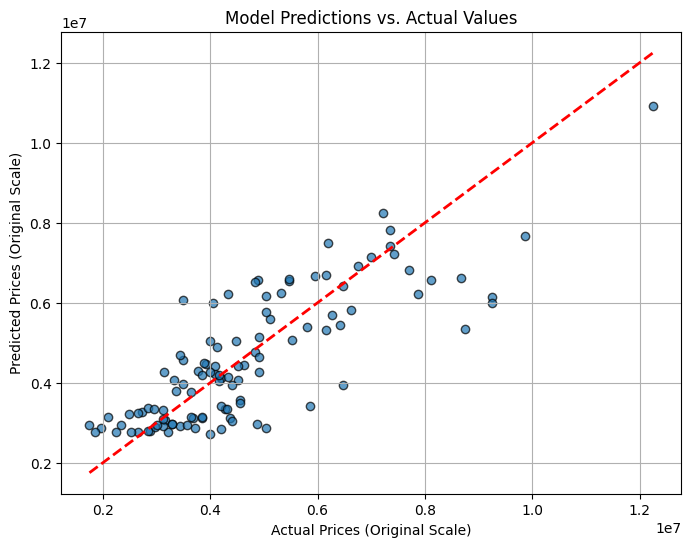

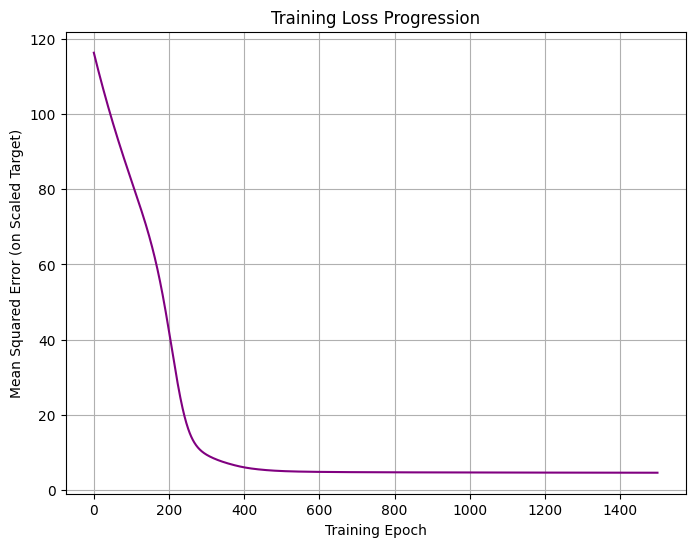

In [6]:

# 6. Model Evaluation
# Get predictions on train and test sets
final_train_preds_scaled = rectified_linear_unit(features_train.dot(weights_input_hidden) + bias_hidden).dot(weights_hidden_output) + bias_output
final_test_preds_scaled = rectified_linear_unit(features_test.dot(weights_input_hidden) + bias_hidden).dot(weights_hidden_output) + bias_output

# Rescale predictions and targets back to original price values
final_train_preds_original = final_train_preds_scaled * target_scaler
final_test_preds_original = final_test_preds_scaled * target_scaler
target_train_original = target_train * target_scaler
target_test_original = target_test * target_scaler

# Display performance metrics
print("\n--- Model Performance ---")
print(f"Train MSE: {mean_squared_error_loss(target_train_original, final_train_preds_original):,.2f}")
print(f"Test MSE: {mean_squared_error_loss(target_test_original, final_test_preds_original):,.2f}")
print(f"Train RMSE: {root_mean_squared_error(target_train_original, final_train_preds_original):,.2f}")
print(f"Test RMSE: {root_mean_squared_error(target_test_original, final_test_preds_original):,.2f}")
print(f"Train MAE: {mean_absolute_error(target_train_original, final_train_preds_original):,.2f}")
print(f"Test MAE: {mean_absolute_error(target_test_original, final_test_preds_original):,.2f}")
print(f"Train R-squared: {r_squared(target_train_original, final_train_preds_original):.4f}")
print(f"Test R-squared: {r_squared(target_test_original, final_test_preds_original):.4f}")

# 6.2 Visualize Predictions vs Actuals
plt.figure(figsize=(8, 6))
plt.scatter(target_test_original, final_test_preds_original, alpha=0.7, edgecolors='k')
plt.xlabel("Actual Prices (Original Scale)")
plt.ylabel("Predicted Prices (Original Scale)")
plt.title("Model Predictions vs. Actual Values")
plt.plot([target_test_original.min(), target_test_original.max()], [target_test_original.min(), target_test_original.max()], 'r--', lw=2)
plt.grid(True)
plt.show()

# 6.3 Visualize Training Loss
plt.figure(figsize=(8, 6))
plt.plot(epoch_losses, color='purple')
plt.xlabel("Training Epoch")
plt.ylabel("Mean Squared Error (on Scaled Target)")
plt.title("Training Loss Progression")
plt.grid(True)
plt.show()


In [7]:

# 7. Persist Model Artifacts
os.makedirs("model_artifacts", exist_ok=True)
np.save("model_artifacts/weights1.npy", weights_input_hidden)
np.save("model_artifacts/bias1.npy", bias_hidden)
np.save("model_artifacts/weights2.npy", weights_hidden_output)
np.save("model_artifacts/bias2.npy", bias_output)

evaluation_metrics = {
    "train_mse": float(mean_squared_error_loss(target_train_original, final_train_preds_original)),
    "test_mse": float(mean_squared_error_loss(target_test_original, final_test_preds_original)),
    "train_rmse": float(root_mean_squared_error(target_train_original, final_train_preds_original)),
    "test_rmse": float(root_mean_squared_error(target_test_original, final_test_preds_original)),
    "train_mae": float(mean_absolute_error(target_train_original, final_train_preds_original)),
    "test_mae": float(mean_absolute_error(target_test_original, final_test_preds_original)),
    "train_r2": float(r_squared(target_train_original, final_train_preds_original)),
    "test_r2": float(r_squared(target_test_original, final_test_preds_original)),
}
pd.Series(evaluation_metrics).to_json("model_artifacts/evaluation_report.json", indent=4)

print("\nProcess Complete: Model trained for more epochs and artifacts saved.")


Process Complete: Model trained for more epochs and artifacts saved.
